In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)
%cd "/content/drive/My Drive/automatic-asset-classification"
%ls "/content/drive/My Drive/automatic-asset-classification"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification
data/  models/


In [0]:
np.random.seed(3333)
torch.manual_seed(3333)
image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
size = 224
batchsize = 32

tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).split_by_rand_pct().label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

In [0]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True)
        )
        
    def encode(self,x): return self.encoder(x)
    
    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)
        

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return torch.clamp(decoded, min=0, max=1)

In [0]:
autoencoder = AutoEncoder()
learn = Learner(data, autoencoder, loss_func=F.mse_loss);
learn = learn.load('ae_no1')

In [0]:
train_batches = [item[0] for item in iter(data.train_dl)]
valid_batches = [item[0] for item in iter(data.valid_dl)]

In [0]:
autoencoder.eval()
encoded_train_batches = [];
encoded_valid_batches = [];

with torch.no_grad():

  for train in train_batches:
    encoded_train = autoencoder.encode(train);
    encoded_train_batches.append(encoded_train);
  
  for valid in valid_batches:
    encoded_valid = autoencoder.encode(valid);
    encoded_valid_batches.append(encoded_valid);

In [15]:
encoded_train[0].unsqueeze(0).shape

torch.Size([1, 64, 112, 112])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


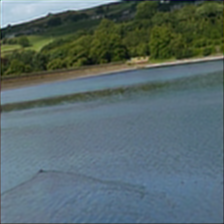

In [24]:
Image(autoencoder.decode(encoded_train[0].unsqueeze(0)).squeeze(0).detach())

In [0]:
del train_batches
del valid_batches
del data
del src
del autoencoder
del learn

# Autoencoder - Layer 2

In [0]:
class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(64, 112, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(112, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.Tanh()
        )
    def encode(self,x): return self.encoder(x)
    def decode(self,x): return self.decoder(x)
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Create the training data which is the encoded output from the first autoencoder.

In [10]:
#encoded_train_batches = torch.cat([batch.cpu() for batch in encoded_train_batches])
#encoded_valid_batches = torch.cat([batch.cpu() for batch in encoded_valid_batches])
#print(encoded_train_batches.shape), print(encoded_valid_batches.shape)

torch.Size([384, 64, 112, 112])
torch.Size([96, 64, 112, 112])


(None, None)

In [28]:
encoded_train_batches = np.concatenate([batch.cpu().numpy() for batch in encoded_train_batches])
encoded_valid_batches = np.concatenate([batch.cpu().numpy() for batch in encoded_valid_batches])
print(encoded_train_batches.shape), print(encoded_valid_batches.shape)

(384, 64, 112, 112)
(96, 64, 112, 112)


(None, None)

In [0]:
class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = 2 # binary label
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
train_ds, valid_ds = ArrayDataset(encoded_train_batches, encoded_train_batches), ArrayDataset(encoded_valid_batches, encoded_valid_batches)

In [0]:
data2 = DataBunch.create(train_ds, valid_ds, bs=32)

In [0]:
autoencoder2 = AutoEncoder2()
learn2 = Learner(data2, autoencoder2, loss_func = F.mse_loss)

In [33]:
learn2.lr_find()

epoch,train_loss,valid_loss,time
0,0.660421,#na#,00:02
1,0.648405,#na#,00:02
2,0.586018,#na#,00:02
3,0.457528,#na#,00:02
4,0.361681,#na#,00:02
5,0.309994,#na#,00:02
6,0.282019,#na#,00:02
7,0.276658,#na#,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-04
Min loss divided by 10: 1.58E-01


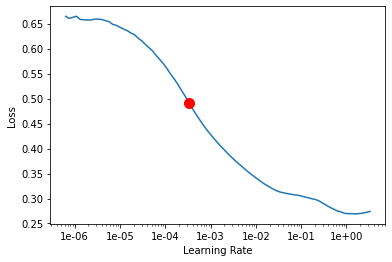

In [34]:
learn2.recorder.plot(suggestion=True)

In [35]:
learn2.fit_one_cycle(100, max_lr = 1e-03)

epoch,train_loss,valid_loss,time
0,0.453075,0.292429,00:02
1,0.347402,0.177165,00:02
2,0.273997,0.124377,00:02
3,0.222147,0.103999,00:02
4,0.186025,0.094225,00:02
5,0.160243,0.089959,00:02
6,0.141411,0.086070,00:02
7,0.127462,0.081987,00:02
8,0.116693,0.079620,00:02
9,0.108278,0.077141,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Because we still see decreasing losses and this network is far quicker to train, it may be worth doing a few more epochs until we see decreases.

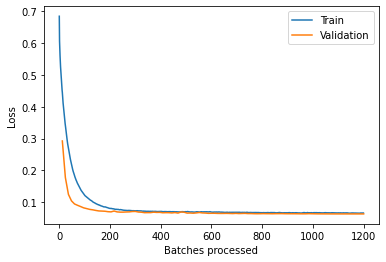

In [36]:
learn2.recorder.plot_losses()

In [0]:
learn2.save('ae_no2')

In [0]:
autoencoder = AutoEncoder()
learn = Learner(data, autoencoder, loss_func=F.mse_loss);
learn = learn.load('ae_no1')

### Example

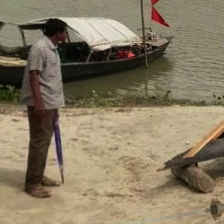

In [59]:
data.train_ds[0][0]

In [0]:
example = data.train_ds[0][0].data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

Original Autoencoder prediction:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


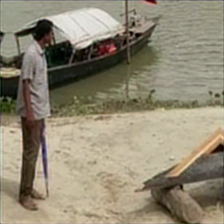

In [61]:
autoencoder.eval()
with torch.no_grad():
  pred = autoencoder(example.unsqueeze_(0).cuda())

Image(pred.squeeze(0).cpu())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


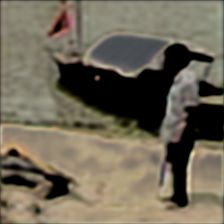

In [63]:
example = data.train_ds[0][0].data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

autoencoder.eval()
autoencoder2.eval()
with torch.no_grad():
  pred = autoencoder.encode(example.unsqueeze_(0).cuda())
  pred = autoencoder2(pred)
  pred = autoencoder.decode(pred)

Image(pred.squeeze(0).cpu())

### example 2

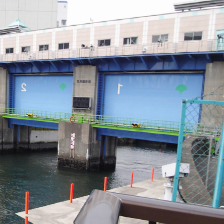

In [74]:
data.train_ds[120][0]

In [0]:
example = data.train_ds[120][0].data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


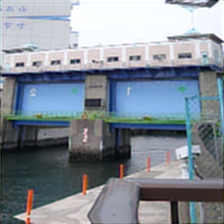

In [76]:
autoencoder.eval()
with torch.no_grad():
  pred = autoencoder(example.unsqueeze_(0).cuda())

Image(pred.squeeze(0).cpu())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


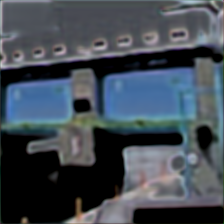

In [77]:
example = data.train_ds[120][0].data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

autoencoder.eval()
autoencoder2.eval()
with torch.no_grad():
  pred = autoencoder.encode(example.unsqueeze_(0).cuda())
  pred = autoencoder2(pred)
  pred = autoencoder.decode(pred)

Image(pred.squeeze(0).cpu())

So from both examples - the final image is bad quality, however what can be seen is the assets are being left which is what we hoped the model would learn. Example one contains an embankment, the model did not learn to recreate the person or boat but instead had learned to recreate the embankment which can be seen in many examples.

Similarly, with the flood gate, the main feature we see in the encoded version. It is clear when in a supervised manor that using an autoencoder in this domain would be extremely helpful as it removed any background noise which could take the model away from learning the true representation.

At this level, the model has not compressed much and we are losing quality. It will become harder at each level to keep compressing and recreating the image.

# Old training loop:

Define the parameters.

In [0]:
bs = 32
epoch = 100

Training loop:

In [0]:
autoencoder2 = AutoEncoder2()

In [0]:
class encoderDataset():
  def __init__(self, x): self.x,self.y = x,x
  def __len__(self): return len(self.x)
  def __getitem__(self, i): return self.x[i],self.y[i]

In [0]:
train_ds,valid_ds = encoderDataset(encoded_train_batches),encoderDataset(encoded_valid_batches)

In [0]:
from torch.utils.data import DataLoader

In [0]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [0]:
lr = 0.01
opt = torch.optim.SGD(autoencoder2.parameters(), lr=lr)

for epoch in range(epochs):

  for xb,yb in train_dl:
    autoencoder2.train()

    loss = F.mse_loss(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()


    model.eval()
    with torch.no_grad():
        tot_loss,tot_acc = 0.,0.
        for xb,yb in valid_dl:
            pred = model(xb)
            tot_loss += loss_func(pred,yb)
            tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
